In [45]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
%matplotlib inline

In [46]:
import glob
#Data folders
glaucoma_dir ='E:\\glaucoma_final\\Test\\glaucoma'
healthy_dir = 'E:\\glaucoma_final\\Test\\health'
glaucoma = []
healthy = []
# Read 
images = glob.iglob(glaucoma_dir + '/**/*.jpg', recursive=True)

for image in images:
        glaucoma.append(image)
        
images = glob.iglob(healthy_dir + '/**/*.jpg', recursive=True)

for image in images:
        healthy.append(image)

        
print(len(glaucoma))
print(len(healthy))

20
20


# :::::::::::::::::For Orb:::::::::::::

In [47]:
def Image_preprocessing_orb(images):
    preprocessed_image = []
    for image in images:
        image = cv2.imread(image)
        reshape = cv2.resize(image, (400, 400))
        blue, green, red = cv2.split(reshape)
        clahe = cv2.createCLAHE(clipLimit=5.0, tileGridSize=(8, 8))
        Adaptive_histrogram = clahe.apply(green)
        preprocessed_image.append(Adaptive_histrogram)
    return preprocessed_image

glaucoma_preprocessing_orb = Image_preprocessing_orb(glaucoma)
healthy_preprocessing_orb= Image_preprocessing_orb(healthy)


def Orb_feature_extraction(images):
    orb_feature_extracted = []
    for image in images:
        image_features = []
        feature_image = np.copy(image)
        orb_features = []
        orb = cv2.ORB_create(nfeatures=500)
        keypoints_orb, descriptors = orb.detectAndCompute(feature_image, None)
        orb_features.append(descriptors[0:200])
        orb_features = np.ravel(orb_features)
        image_features.append(orb_features)
        orb_feature_extracted.append(np.concatenate(image_features))
    return orb_feature_extracted

glaucoma_feature_orb = Orb_feature_extraction(glaucoma_preprocessing_orb)
healthy_feature_orb = Orb_feature_extraction(healthy_preprocessing_orb)

X_orb = np.vstack((glaucoma_feature_orb,healthy_feature_orb)).astype(np.float64)

y_orb = np.hstack((np.zeros(len(glaucoma_feature_orb)), np.ones(len(healthy_feature_orb))))

import pickle
filename = 'E:\\glaucoma_final\\finalized_model_gnb.sav'
gnb = pickle.load(open(filename, 'rb'))
y_pred_orb = gnb.predict(X_orb)

In [48]:
probs_orb = gnb.predict_proba(X_orb)
probs_orb = probs_orb[:, 1]
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
fpr_orb, tpr_orb, thresholds_orb = roc_curve(y_orb, probs_orb)
auc_orb = roc_auc_score(y_orb, probs_orb)
print('AUC: %.2f' % auc_orb)

AUC: 0.94


# ::::::::::::::::For Brief::::::::::::

In [49]:
def Image_preprocessing_Brief(images):
    preprocessed_image = []
    for image in images:
        image = cv2.imread(image)
        reshape = cv2.resize(image, (400, 400))
        blue, green, red = cv2.split(reshape)
        equ = cv2.equalizeHist(green)
        preprocessed_image.append(equ)
    return preprocessed_image

glaucoma_preprocessing_Brief = Image_preprocessing_Brief(glaucoma)
healthy_preprocessing_Brief = Image_preprocessing_Brief(healthy)


def brief_feature_extraction(images):
    brief_feature_extracted = []
    for image in images:
        image_features = []
        feature_image = np.copy(image)
        brief_features = []
        fast = cv2.FastFeatureDetector_create()
        brief = cv2.xfeatures2d.BriefDescriptorExtractor_create()
        keypoints = fast.detect(feature_image, None)
        keypoints_brief, descriptors = brief.compute(feature_image, keypoints)
        brief_features.append(descriptors[0:200])
        brief_features = np.ravel(brief_features)
        image_features.append(brief_features)
        brief_feature_extracted.append(np.concatenate(image_features))
    return brief_feature_extracted

glaucoma_feature_brief = brief_feature_extraction(glaucoma_preprocessing_Brief)
healthy_feature_brief = brief_feature_extraction(healthy_preprocessing_Brief)

X_brief = np.vstack((glaucoma_feature_brief,healthy_feature_brief)).astype(np.float64)
y_brief = np.hstack((np.zeros(len(glaucoma_feature_brief)), np.ones(len(healthy_feature_brief))))

filename = 'E:\\glaucoma_final\\finalized_model_brief_svc.sav'
svc = pickle.load(open(filename, 'rb'))

y_pred_brief = svc.predict(X_brief)
probs_brief = svc.predict_proba(X_brief)
probs_brief = probs_brief[:,1]

fpr_brief, tpr_brief, thresholds_brief = roc_curve(y_brief, probs_brief)
auc_brief = roc_auc_score(y_brief, probs_brief)


# :::::::::::::::::::::HOG:::::::::::::::::

In [50]:
def Image_preprocessing_Hog(images):
    preprocessed_image = []
    for image in images:
        image = cv2.imread(image)
        reshape = cv2.resize(image, (400, 400))
        blue, green, red = cv2.split(reshape)
        clahe = cv2.createCLAHE(clipLimit=5.0, tileGridSize=(8, 8))
        Adaptive_histrogram = clahe.apply(green)
        preprocessed_image.append(Adaptive_histrogram)
    return preprocessed_image

def build_filters():
    """ returns a list of kernels in several orientations
    """
    filters = []
    ksize = 3
    for theta in np.arange(0, np.pi, np.pi / 32):
        params = {'ksize':(ksize, ksize), 'sigma':1.0, 'theta':theta, 'lambd':35.0,
                  'gamma':0.02, 'psi':0, 'ktype':cv2.CV_32F}
        kern = cv2.getGaborKernel(**params)
        kern /= 1.5*kern.sum()
        filters.append((kern,params))
    return filters

def process(img, filters):
    """ returns the img filtered by the filter list
    """
    accum = np.zeros_like(img)
    for kern,params in filters:
        fimg = cv2.filter2D(img, cv2.CV_8UC3, kern)
        np.maximum(accum, fimg, accum)
    return accum

def Gabor_filter(images):
    gabor_images= []
    for image in images:
        filters = build_filters()
        gabor_image = process(image, filters)
        gabor_images.append(gabor_image)
    return gabor_images

def bottom_hat_filter(images):
    bottom_hat_images = []
    for image in images:
        kernel = np.ones((7,7),np.uint8)
        bottomhat = cv2.morphologyEx(image, cv2.MORPH_BLACKHAT, kernel)
        bottom_hat_images.append(bottomhat)
    return bottom_hat_images

def Threshold_image(images):
    images_thresholding = []
    for image in images:
        mean_value = image.mean()
        std_value = image.std()
        thresh = (mean_value+std_value)
        r, c = image.shape
        Dd = np.zeros(shape=(r, c))
        Dc = np.zeros(shape=(r, c))
        for i in range(1, r):
            for j in range(1, c):
                if image[i, j] >=thresh:
                    Dd[i, j] = 0
                else:
                    Dd[i, j] = 1
        images_thresholding.append(Dd)
    return images_thresholding


def dark_blood_vessal(thresholding_value, real_image):
    dark_vessal_images = []
    for i in range(len(thresholding_value)):
        dark_image = (thresholding_value[i]*real_image[i])
        dark_vessal_images.append(dark_image)
    return dark_vessal_images


from skimage.feature import hog
import scipy

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    """
    Return the hog features of the given input image
    Call with two outputs if vis==True"""
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features
    


def feature_extraction_Hog(images):
    image_features = []
    for image in images:
        feature = []
        features = get_hog_features(image ,9, 8, 2,vis=False, feature_vec=True)
        features = np.ravel(features)
        feature.append(features.mean())
        feature.append(scipy.stats.skew(features, axis=0, bias=True))
        feature.append(scipy.stats.kurtosis(features))
        feature.append(scipy.stats.entropy(features))
        feature.append(np.var(features))
        transpose = np.transpose(feature)
        image_features.append(transpose)
    return image_features

In [51]:
glaucoma_preprocessing_Hog = Image_preprocessing_Hog(glaucoma)
healthy_preprocessing_Hog = Image_preprocessing_Hog(healthy)


glaucoma_after_gabor = Gabor_filter(glaucoma_preprocessing_Hog)
healthy_after_gabor = Gabor_filter(healthy_preprocessing_Hog)


glaucoma_after_bottom_hat = bottom_hat_filter(glaucoma_after_gabor)
healthy_after_bottom_hat = bottom_hat_filter(healthy_after_gabor)


glaucoma_after_threshold = Threshold_image(glaucoma_after_bottom_hat)
healthy_after_threshold = Threshold_image(healthy_after_bottom_hat)


glaucoma_dark = dark_blood_vessal(glaucoma_after_threshold,glaucoma_preprocessing_Hog)
healthy_dark = dark_blood_vessal(healthy_after_threshold,healthy_preprocessing_Hog)


glaucoma_feature_Hog = feature_extraction_Hog(glaucoma_dark)
healthy_feature_hog = feature_extraction_Hog(healthy_dark)

X_Hog = np.vstack((glaucoma_feature_Hog,healthy_feature_hog)).astype(np.float64)
y_Hog = np.hstack((np.zeros(len(glaucoma_feature_Hog)), np.ones(len(healthy_feature_hog))))


c:\users\marzan\appdata\local\programs\python\python35\lib\site-packages\skimage\feature\_hog.py:239: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


In [52]:

filename = 'E:\\glaucoma_final\\finalized_model_hog.sav'
svc_hog = pickle.load(open(filename, 'rb'))

y_pred_hog = svc_hog.predict(X_Hog)
probs_hog = svc_hog.predict_proba(X_Hog)
probs_hog = probs_hog[:,1]
fpr_hog, tpr_hog, thresholds_hog = roc_curve(y_Hog, probs_hog)
auc_hog = roc_auc_score(y_Hog, probs_hog)

# :::::::::::::::::ROC CURVE:::::::::::::

In [53]:
def plot_roc_curve(fpr1, tpr1, fpr2, tpr2, fpr3, tpr3):
    plt.plot(fpr1, tpr1, color='orange', label='ORB Accuracy 94%')
    plt.plot(fpr2, tpr2, color='green', label='Brief Accuracy 80%')
    plt.plot(fpr3, tpr3, color='red', label='Hog Accuracy 78%')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

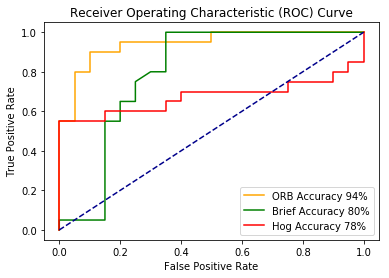

In [54]:
plot_roc_curve(fpr_orb, tpr_orb, fpr_brief, tpr_brief, fpr_hog, tpr_hog)